In [2]:
import os
import pandas as pd
from glob import glob
from PIL import Image
from google.colab import drive

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
base_path = '/content/drive/MyDrive'
sub_path = 'Advanced Machine Learning/skin disease detection fusion model'
full_path = os.path.join(base_path, sub_path)

# Check folders in directory
print("Folders in path:", os.listdir(full_path))

# Step 1: Gather image paths from multiple folders
image_folders = ['images1', 'images2', 'images3']
image_paths = []
for folder in image_folders:
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths += glob(os.path.join(full_path, folder, ext))

print(f"Found {len(image_paths)} image files.")

# Step 2: Map image file names to their full paths
image_map = {os.path.basename(path): path for path in image_paths}

# Step 3: Load and prepare metadata
df = pd.read_csv(os.path.join(full_path, "cleaned_metadata.csv"))
df['img_path'] = df['img_id'].map(image_map)
# Removes any rows where img_path is NaN
df = df.dropna(subset=['img_path'])
print(df.shape)

Mounted at /content/drive
Folders in path: ['metadata.csv', '.git', 'images1', '.ipynb_checkpoints', 'images2', 'images3', 'scaler_metadata.pkl', 'cleaned_metadata.csv', 'preprocessing.ipynb', 'Testing_phase_2.ipynb', 'only_Encoder.ipynb', 'ADV_Project.ipynb', 'Full_Autoencoders.ipynb', 'Testing.ipynb', 'Replication_of_ADV_Project (1).ipynb']
Found 2298 image files.
(2298, 60)


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'smoke', 'drink', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2',
       'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation',
       'img_id', 'biopsed', 'region_ARM', 'region_BACK', 'region_CHEST',
       'region_EAR', 'region_FACE', 'region_FOOT', 'region_FOREARM',
       'region_HAND', 'region_LIP', 'region_NECK', 'region_NOSE',
       'region_SCALP', 'region_THIGH', 'background_father_BRASIL',
       'background_father_BRAZIL', 'background_father_CZECH',
       'background_father_GERMANY', 'background_father_ISRAEL',
       'background_father_ITALY', 'background_father_NETHERLANDS',
       'background_father_POLAND', 'background_father_POMERANIA',
       'background_father_PORTUGAL', 'background_father_SPAIN',
       'background_father_UNK', 'background_father_Unknown',
       'background_mother_FRANCE', 'background_mother_GE

First, using pretrain model, we will extract the feature.

In [4]:
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define models
pretrained_models = {
    'ResNet50': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'GoogleNet': models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT),
    'MobileNet': models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT),
    'VGG13': models.vgg13_bn(weights=models.VGG13_BN_Weights.DEFAULT),
}

# Move models to GPU and set to eval
for name, model in pretrained_models.items():
    if hasattr(model, 'fc'):
        model.fc = nn.Identity()
    elif hasattr(model, 'classifier'):
        model.classifier = nn.Identity()
    model = model.to(device)
    model.eval()
    pretrained_models[name] = model  # update in dict

# Extract features
features_dict = {name: [] for name in pretrained_models}
# df_sample = df.sample(n=1000, random_state=42).reset_index(drop=True)


for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features for all models"):
    try:
        img = Image.open(row['img_path']).convert('RGB')
        tensor = transform(img).unsqueeze(0).to(device)  # Move to GPU
        with torch.no_grad():
            for model_name, model in pretrained_models.items():
                output = model(tensor)
                if output.ndim > 2:
                    output = torch.flatten(output, 1)
                # Move back to CPU before numpy
                features_dict[model_name].append(output.squeeze().cpu().numpy())
    except Exception as e:
        for model_name in features_dict:
            features_dict[model_name].append(np.full((1,), np.nan))

# Save features as CSV
for model_name, features in features_dict.items():
    feature_arr = np.vstack(features)
    features_df = pd.DataFrame(feature_arr)
    features_df.index = df.index
    features_df.to_csv(f"{model_name.lower()}_features.csv", index=False)


Using device: cpu


Extracting features for all models: 100%|██████████| 2298/2298 [22:24<00:00,  1.71it/s]


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch.nn as nn

# Simple fusion MLP
class FusionMLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(epochs, train_loader, val_loader, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            out = model(batch_X)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec:.4f}")
    print(f"Recall (weighted): {rec:.4f}")
    print(f"F1 (weighted): {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return model, acc, prec, rec, f1, cm


def train_fusion_model(image_feat_path, df, y, epochs=10):
    img_feat = pd.read_csv(image_feat_path)
    meta = df.drop(columns=['img_id', 'diagnostic', 'Unnamed: 0', 'img_path']).astype(np.float32)
    X = np.hstack([img_feat.values, meta.values])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    fold_cms = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # Create TensorDatasets
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        model = FusionMLP(input_dim=X.shape[1], n_classes=len(np.unique(y)))
        model, acc, prec, rec, f1, cm = train_model(epochs, train_loader, val_loader, model)
        fold_results.append((acc, prec, rec, f1, cm))
        fold_cms.append(cm)

    # Optionally average metrics over folds or return full results
    avg_acc = np.mean([res[0] for res in fold_results])
    avg_prec = np.mean([res[1] for res in fold_results])
    avg_rec = np.mean([res[2] for res in fold_results])
    avg_f1 = np.mean([res[3] for res in fold_results])

    sum_cm = np.sum(fold_cms, axis=0)
    print("Summed Confusion Matrix Across All Folds:")
    print(sum_cm)

    return model, avg_acc, avg_prec, avg_rec, avg_f1, sum_cm, fold_results  # Return all fold results if needed


In [ ]:
results = []

# Example loop (assuming you have your train_fusion_model function)
for feat_csv, model_name in zip(
    ["resnet50_features.csv", "googlenet_features.csv", "mobilenet_features.csv", "vgg13_features.csv"],
    ["ResNet50", "GoogleNet", "MobileNet", "VGG13"]
):
    print(f"\nResults for {model_name}:")
    model, acc, prec, rec, f1, cm, fold_result = train_fusion_model(
        image_feat_path=feat_csv,
        df=df,
        y=df['diagnostic'].values,
        epochs=100
    )
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ConfusionMatrix": cm
    })


In [ ]:
print(results)

<Figure size 1000x600 with 0 Axes>

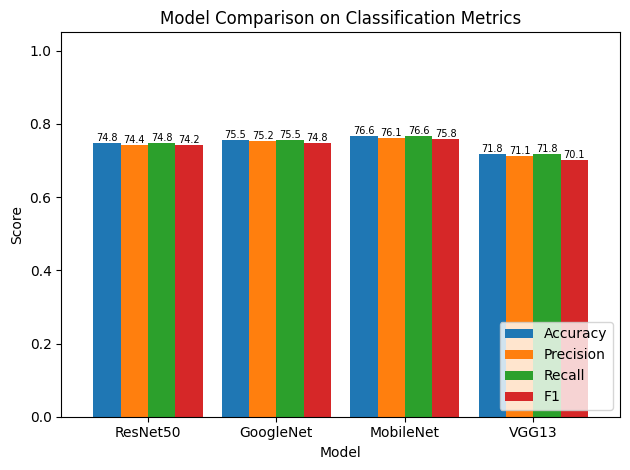

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

results = [
    {'Model': 'ResNet50', 'Accuracy': 0.7476, 'Precision': 0.7435, 'Recall': 0.7476, 'F1': 0.7421},
    {'Model': 'GoogleNet', 'Accuracy': 0.7555, 'Precision': 0.7522, 'Recall': 0.7555, 'F1': 0.7480},
    {'Model': 'MobileNet', 'Accuracy': 0.7659, 'Precision': 0.7609, 'Recall': 0.7659, 'F1': 0.7585},
    {'Model': 'VGG13', 'Accuracy': 0.7176, 'Precision': 0.7113, 'Recall': 0.7176, 'F1': 0.7010}
]

df_metrics = pd.DataFrame(results)
df_metrics.set_index("Model", inplace=True)

plt.figure(figsize=(10, 6))
ax = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', width=0.85)
plt.ylim(0, 1.05)
plt.title("Model Comparison on Classification Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()

# Add percentage labels to each bar, smaller font and one decimal
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.1f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=7, rotation=0)

plt.show()


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

conf_matrix_vgg13 = np.array([
    [575, 119,   1,   7,  18,  10],
    [ 86, 712,   1,  14,  28,   4],
    [  3,  11,  22,  10,   0,   6],
    [  9,  18,   4, 179,   2,  32],
    [ 40, 114,   0,   4,  33,   1],
    [ 52,  17,   2,  32,   4, 128]
])

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_vgg13.astype('float') / conf_matrix_vgg13.sum(axis=1)[:, np.newaxis]

# Define class labels
labels = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

# Plot confusion matrix heatmap with better color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title("Confusion Matrix - VGG13 (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [ ]:
# def calculate_background():
#   # Select N background samples
#   N = 100  # keep this small for KernelExplainer or SHAP Deep

#   background_df = df.sample(n=N, random_state=42)

#   # Compute image features (using pretrained CNN, e.g., ResNet)
#   image_features_background = []
#   meta_features_background = []

#   for _, row in background_df.iterrows():
#       # Load image
#       img = Image.open(row['img_path']).convert("RGB")
#       img_tensor = transform(img).unsqueeze(0).to(device)
#       with torch.no_grad():
#           img_feat = model(img_tensor)
#           if img_feat.ndim > 2:
#               img_feat = torch.flatten(img_feat, 1)
#           image_features_background.append(img_feat.cpu().numpy())

#       # Get metadata
#       meta = row.drop(['img_id', 'img_path', 'diagnostic', 'Unnamed: 0'], errors='ignore').values.astype(np.float32)
#       meta_features_background.append(meta)

#   # Convert to NumPy arrays
#   image_features_background = np.vstack(image_features_background)  # Shape: [N, image_feat_dim]
#   meta_features_background = np.vstack(meta_features_background)    # Shape: [N, meta_feat_dim]

#   return image_features_background, meta_features_background

In [10]:
pip install torchcam --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [18]:
import os
import torch
import shap
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchcam.methods import GradCAM
from PIL import Image

# ========== SETTINGS ==========
TARGET_CLASS = 0
OUTPUT_DIR = 'saved_gradcam'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========== TRANSFORMS ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ========== IMAGE FEATURE EXTRACTOR ==========
cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
cnn_feature_extractor = torch.nn.Sequential(*list(cnn.children())[:-1])
cnn.eval()


# Load your fusion model (adjust input_dim & num_classes!)
fusion_model = FusionMLP(
    input_dim=2048 + (df.shape[1] - 4),
    n_classes=len(df['diagnostic'].unique())
)
fusion_model.eval()

# ========== GRADCAM ==========
cam_extractor = GradCAM(cnn, target_layer='layer4')

# ========== BACKGROUND FOR SHAP ==========
def calculate_background_from_csv(image_feat_path, df, target_class, n=20):
    # Load pre-extracted image features
    image_feat = pd.read_csv(image_feat_path)

    # Prepare metadata (must be in same order as image features)
    meta = df.drop(columns=['img_id', 'diagnostic', 'Unnamed: 0', 'img_path'], errors='ignore').astype(np.float32)

    # Filter by target class
    target_indices = df[df['diagnostic'] == target_class].index
    if len(target_indices) < n:
        raise ValueError(f"Not enough samples for target class {target_class}")

    selected_indices = np.random.choice(target_indices, size=n, replace=False)

    # Slice image and meta features
    image_background = image_feat.iloc[selected_indices].values
    meta_background = meta.iloc[selected_indices].values

    # Combine into tensor
    combined_background = np.hstack([image_background, meta_background])
    return torch.tensor(combined_background, dtype=torch.float32)

background = calculate_background_from_csv(
    image_feat_path='resnet50_features.csv',
    df=df,
    target_class=TARGET_CLASS,
    n=20
)
explainer = shap.DeepExplainer(fusion_model, background)

# ========== MAIN LOOP ==========
for idx, row in df.iterrows():
    if row['diagnostic'] != TARGET_CLASS:
        continue

    try:
        image_path = row['img_path']
        img = Image.open(image_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0)

        # Grad-CAM logic
        output = cnn(input_tensor)
        pred_class = output.argmax().item()
        cam = cam_extractor(class_idx=pred_class, scores=output)[0]
        cam_resized = F.interpolate(
            cam.unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze().detach().cpu().numpy()
        # Denormalize image
        image_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image_np = np.clip(image_np, 0, 1)

        # Save Grad-CAM
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(image_np)
        ax[0].set_title("Original")
        ax[0].axis('off')
        ax[1].imshow(image_np)
        ax[1].imshow(cam_resized, cmap='jet', alpha=0.5)
        ax[1].set_title(f"Grad-CAM (Predicted: {pred_class})")
        ax[1].axis('off')
        plt.tight_layout()
        save_path = os.path.join(OUTPUT_DIR, os.path.basename(image_path).replace(".jpg", "_gradcam.png"))
        plt.savefig(save_path)
        plt.close()
        print(f"[Saved] {save_path}")

        # SHAP Logic
        image_feat = pd.read_csv('resnet50_features.csv')
        meta_tensor = torch.tensor(
            row.drop(['img_id', 'img_path', 'diagnostic', 'Unnamed: 0'], errors='ignore').values.astype(np.float32)
        )
        combined_input = torch.cat([image_feat, meta_tensor]).unsqueeze(0)
        shap_values = explainer.shap_values(combined_input)
        meta_shap = shap_values[0][:, -meta_tensor.shape[0]:]
        print(f"[SHAP] Metadata SHAP values for {os.path.basename(image_path)}:")
        print(meta_shap)



    except Exception as e:
        print(f"[Warning] Failed on image {row['img_path']}: {e}")


[Saved] saved_gradcam/PAT_1545_1867_547.png
[Warning] Failed on image /content/drive/MyDrive/Advanced Machine Learning/skin disease detection fusion model/images3/PAT_1545_1867_547.png: Tensors must have same number of dimensions: got 1 and 2
[Saved] saved_gradcam/PAT_1989_4061_934.png
[Warning] Failed on image /content/drive/MyDrive/Advanced Machine Learning/skin disease detection fusion model/images3/PAT_1989_4061_934.png: Tensors must have same number of dimensions: got 1 and 2
[Saved] saved_gradcam/PAT_1995_4080_695.png
[Warning] Failed on image /content/drive/MyDrive/Advanced Machine Learning/skin disease detection fusion model/images3/PAT_1995_4080_695.png: Tensors must have same number of dimensions: got 1 and 2
[Saved] saved_gradcam/PAT_705_4015_413.png
[Warning] Failed on image /content/drive/MyDrive/Advanced Machine Learning/skin disease detection fusion model/images2/PAT_705_4015_413.png: Tensors must have same number of dimensions: got 1 and 2
[Saved] saved_gradcam/PAT_2140